<a href="https://colab.research.google.com/github/IrfanChairurrachman/cats-vs-dogs/blob/master/KC_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project 4A

Nama Kelompok:

1. 18106050005 - Farah Aura Dody Effendi
2. 18106050016 - Irfan Chairurrachman
3. 18106050022 - Galih Redha Saputra

---


## 1. Persiapan Data

Sesi persiapan data kucing dan anjing, mulai dengan mengimport module-module yang diperlukan dalam pengembangan model Machine Learning. Salah satunya adalah library Tensorflow

In [ ]:
import os       # Membantu manajemen file dan folder
import zipfile  # Untuk mengekstrak file ekstensi zip
import random   
import tensorflow as tf     # library tensorflow untuk pelatihan model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # ImageDataGenerator untuk augmentasi gambar
from shutil import copyfile
# /content/sample_data

### Mengunduh Data

Mengunduh data dengan perintah `wget` di terminal dan menyimpannya dalam folder `/content`

In [ ]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip" \
    -O "/content/cats_and_dogs_filtered.zip"

local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

--2021-01-12 06:43:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   190MB/s    in 0.3s    

2021-01-12 06:43:52 (190 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

--2021-01-07 11:25:15--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   254MB/s    in 3.1s    

2021-01-07 11:25:18 (254 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



### Direktori Data

Menyimpan path file dan folder dalam variabel yang telah ditentukan. 

Disini juga dilakukan pemisahan antara data pelatihan yang akan dipakai oleh model untuk belajar dan data validasi untuk mengukur kemampuan model dengan memberikan data yang belum pernah diliat ketika belajar.

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

### Isi Data

Menampilkan 4 gambar kucing dan 4 gambar anjing yang terpilih (secara berurutan) dengan menggunakan library `matplotlib`.

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

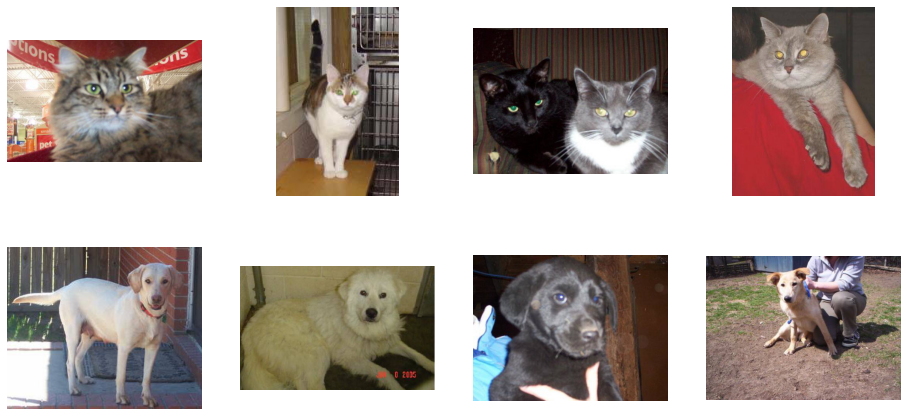

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-4:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 2. Model tanpa Augmentasi

Membuat model dengan input ukuran 150x150 pixel (3 byte warna). Ini dilakukan karena model hanya menerima input dengan ukuran persegi (tinggi dan lebar harus sama).

Layer-layer model terdiri dari operasi konvolusi serta maxpooling. Ini dilakukan untuk mengekstrak fitur yang terdapat pada gambar, sehingga dapat mengurangi ukuran gambar tanpa harus kehilangan informasi penting pada gambar.

Terlihat hasil `model.summary()`, setiap kali melakukan konvolusi maka tepi gambar akan berkurang dan menghasilkan pixel baru dengan informasi yang sama.

Begitu pula setiap melakukan maxpooling, gambar akan kehilangan 3/4 ukurannya.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Generator

Generator membantu model dan komputer dalam proses pelatihan. Pada `ImageDataGenerator(rescale=1./255)` adalah membagi semua piksel dengan pembagi 255. Sehingga nilai piksel berada diantara 0-1 (dengan alasan memudahkan komputer dalam beroperasi).

`class_mode` menggunakan `binary` karena pelatihan ini untuk mengklasifikasikan 2 kelas, yaitu kelas anjing dan kelas kucing. Jika kelas lebih dari 2, biasanya menggunakan `categorical`. 

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Callback**

Callback berfungsi untuk menghentikan pelatihan ketika target akurasi telah tercapai. Ini dilakukan untuk mencegah terjadinya pelatihan yang banyak namun tingkat akurasi mengalami stagnan.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92):
      print("\nAkurasi di atas 92%, hentikan pelatihan!")
      self.model.stop_training = True

callbacks = myCallback()

## Pelatihan

Melakukan pelatihan model dengan 50x `epochs` (pelatihan). Serta memeriksa kemampuan model dengan melihat `val_acc`, yaitu tingkat keberhasilan model dalam menebak gambar yang belum pernah dilihat sebelumnya ketika pelatihan.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=50,
      callbacks = [callbacks])

Epoch 1/50
50/50 [==============================] - 13s 116ms/step - loss: 0.6957 - accuracy: 0.5333 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 6s 112ms/step - loss: 0.6930 - accuracy: 0.5306 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 6s 114ms/step - loss: 0.6866 - accuracy: 0.5573 - val_loss: 0.6710 - val_accuracy: 0.6210
Epoch 4/50
50/50 [==============================] - 6s 112ms/step - loss: 0.6827 - accuracy: 0.5499 - val_loss: 0.6593 - val_accuracy: 0.6270
Epoch 5/50
50/50 [==============================] - 6s 115ms/step - loss: 0.6628 - accuracy: 0.5903 - val_loss: 0.6483 - val_accuracy: 0.6500
Epoch 6/50
50/50 [==============================] - 6s 117ms/step - loss: 0.6454 - accuracy: 0.6436 - val_loss: 0.6759 - val_accuracy: 0.5410
Epoch 7/50
50/50 [==============================] - 6s 112ms/step - loss: 0.6344 - accuracy: 0.6355 - val_loss: 0.6161 - val_accuracy: 0.6820
Epoch

### Grafik Pelatihan

Melakukan plot pada data pelatihan.

Dapat dilihat bahwa `accuracy` dan `val_accuracy` memiliki jarak yang cukup jauh. Begitupun dengan `loss` dengan `val_loss`.

Ini menandakan model mengalami *overfit*. Yaitu kondisi dimana model kelebihan performa saat pelatihan, namun performa di dunia nyata (atau ketika melihat gambar validasi) buruk.

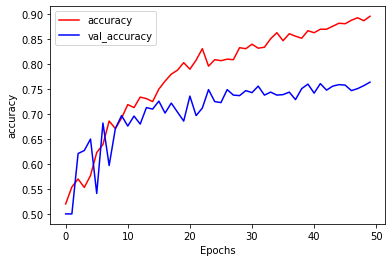

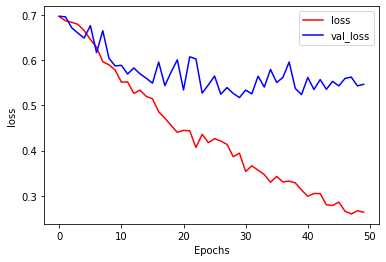

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  epochs = range(len(history.history[string]))
  plt.plot(epochs, history.history[string], 'r', label=string)
  plt.plot(epochs, history.history['val_'+string], 'b', label=string+'_val')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Visualisasi Konvolusi

Berikut adalah proses konvolusi yang terjadi di tiap layernya.

Untuk maxpooling, terlihat ukuran gambar mengecil menjadi 1/4 ukuran sebelum operasi citra maxpooling.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


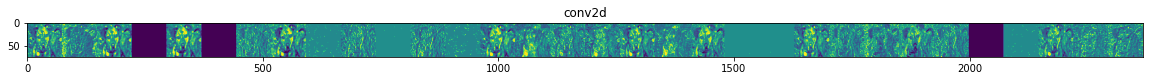

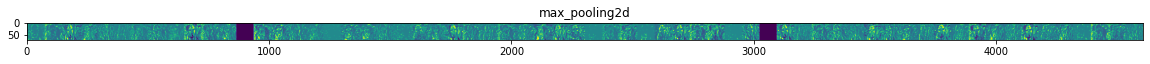

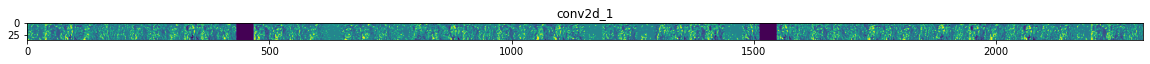

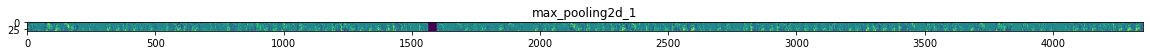

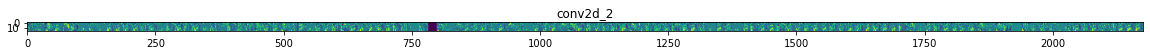

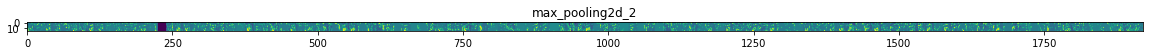

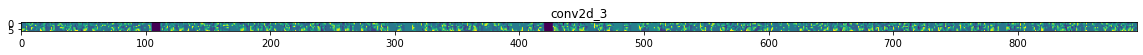

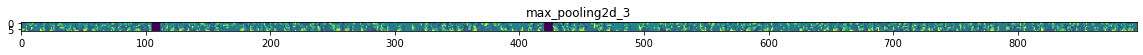

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    # display_grid = np.zeros((size, size * n_features * 5))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = (20. / n_features)
    plt.figure( figsize=(scale * n_features, scale) )
    # plt.figure( figsize=(20, 20) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
    # plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=50,
      callbacks = [callbacks])

Epoch 1/50
50/50 [==============================] - 10s 195ms/step - loss: 0.7007 - accuracy: 0.5037 - val_loss: 0.6877 - val_accuracy: 0.5030
Epoch 2/50
50/50 [==============================] - 10s 192ms/step - loss: 0.6842 - accuracy: 0.5506 - val_loss: 0.6813 - val_accuracy: 0.5720
Epoch 3/50
50/50 [==============================] - 10s 192ms/step - loss: 0.6879 - accuracy: 0.5562 - val_loss: 0.6896 - val_accuracy: 0.5230
Epoch 4/50
50/50 [==============================] - 10s 193ms/step - loss: 0.6847 - accuracy: 0.5450 - val_loss: 0.6624 - val_accuracy: 0.5920
Epoch 5/50
50/50 [==============================] - 10s 192ms/step - loss: 0.6661 - accuracy: 0.5861 - val_loss: 0.6505 - val_accuracy: 0.6350
Epoch 6/50
50/50 [==============================] - 10s 192ms/step - loss: 0.6634 - accuracy: 0.6120 - val_loss: 0.6546 - val_accuracy: 0.6220
Epoch 7/50
50/50 [==============================] - 10s 194ms/step - loss: 0.6637 - accuracy: 0.5815 - val_loss: 0.6382 - val_accuracy: 0.6330

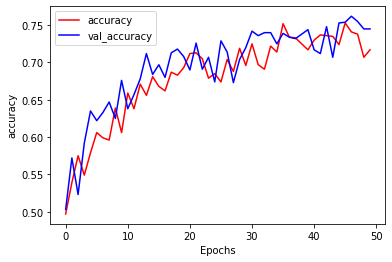

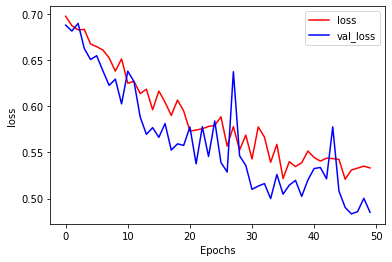

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")